<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/HI_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import diptest

from google.colab import drive

from shapely.geometry import Point

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [3]:
# Preprocess data function
def preprocess_data(matched_data):
    matched_data['distance'] = 0
    matched_data = matched_data[[str(i) == '20' for i in matched_data["depth_adj_bottom"]] ]
    matched_data['imp_c_float'] = matched_data['imp_c'].astype(float)

    # Select ID fields and numeric columns
    id_fields = matched_data[['source_dataset', 'island', 'dist_id', 'soil_column_id', 'unique_id', 'depth_top',
                              'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'x_sample', 'y_sample',
                              'x_driver', 'y_driver']]
    keep_cols = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                 'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI', 'aet', 'def',
                 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs',
                 'agbd_m', 'agbd_sd', 'agbd_n']
    numeric_cols = matched_data[keep_cols].replace('', np.nan).astype(float).fillna(0)

    # Scale numeric columns
    scaler = MinMaxScaler()
    scaled_numeric_cols = scaler.fit_transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

    # Scale imp_c
    min_c = matched_data['imp_c_float'].min()
    max_c = matched_data['imp_c_float'].max()
    scaled_imp_c = (matched_data['imp_c_float'] - min_c) / (max_c - min_c)

    # Combine ID fields with scaled numeric data
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)
    numeric_df['imp_c_scaled'] = scaled_imp_c

    return numeric_df, scaler, min_c, max_c

In [4]:
# Train model function
def train_model(preprocessed_data):
    keep_cols = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                 'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI', 'aet', 'def',
                 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs',
                 'agbd_m', 'agbd_sd', 'agbd_n']
    X = preprocessed_data[keep_cols]
    y = preprocessed_data['imp_c_scaled']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build and compile model
    model = Sequential([
        Dense(256, activation='relu', input_dim=X_train.shape[1]),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test).flatten()
    r_squared = r2_score(y_test, predictions)

    return model, test_loss, r_squared, predictions, y_test

In [5]:
# Predict on reserve function
def predict_on_reserve(preprocessed_data, model, min_c, max_c):
    keep_cols = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI', 'aet', 'def',
                'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs',
                'agbd_m', 'agbd_sd', 'agbd_n']
    X = preprocessed_data[keep_cols]
    predictions = model.predict(X)

    inversed_predictions = predictions * (max_c - min_c) + min_c
    inversed_truth = preprocessed_data['imp_c_scaled'] * (max_c - min_c) + min_c

    df_out = preprocessed_data.copy()
    df_out['predictions'] = predictions
    df_out['inversed_predictions'] = inversed_predictions
    df_out['inversed_imp_c'] = inversed_truth

    return df_out

In [6]:
# Evaluate model function
def evaluate_model(model, X_test, y_test, inversed_predictions, inversed_truth):
    test_loss = model.evaluate(X_test, y_test)
    r_squared = r2_score(inversed_truth, inversed_predictions)

    print("Test Loss:", test_loss)
    print("R-Squared Score:", r_squared)

    mae = mean_absolute_error(inversed_truth, inversed_predictions)
    rmse = mean_squared_error(inversed_truth, inversed_predictions, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)

    # Scatter plot of true vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=inversed_truth, y=inversed_predictions)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.plot([min(inversed_truth), max(inversed_truth)], [min(inversed_truth), max(inversed_truth)], 'r')
    plt.show()

    # Residual plot
    residuals = inversed_truth - inversed_predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title("Distribution of Residuals")
    plt.show()


In [7]:
# Cross-validation and model training
def build_model(input_shape, output_shape):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(output_shape, activation='linear')
    ])
    return model

In [8]:
# Define function for rescaling
def rescale_to_minus_one_one(array):
    return 2 * (array - array.min()) / (array.max() - array.min()) - 1


In [9]:
def train_model_a(preprocess_data):

    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                'agbd_m', 'agbd_sd', 'agbd_n']

    X = preprocess_data[keep_cols]

    y = preprocess_data['imp_c_scaled']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define model
    def build_model(input_shape):
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_shape),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='linear')
        ])
        return model

    model = build_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test).flatten()
    r_squared = r2_score(y_test, predictions)

    return model, test_loss, r_squared, predictions, y_test

# Load and preprocess data

In [340]:
# Load data
gdf = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/2024_update/annotated_combo_imputed_SOC.gpkg')
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')
soils_csv = pd.read_csv('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')
labeled_dist = pd.read_csv('/content/drive/MyDrive/hawaii_soils/labeled_distr_annote.csv')

In [341]:
# Preprocess soils data
soils_csv = soils_csv.dropna(subset=['latitude', 'longitude'])
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'])), axis=1)
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")

# Merge and transform GeoDataFrames
soils_gpd = pd.merge(soils_gpd, gdf[['dist_id', 'unique_id']], on='unique_id', how='inner')
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [342]:
# Additional preprocessing steps
drivers_gpd['x_driver'] = drivers_gpd.geometry.x
drivers_gpd['y_driver'] = drivers_gpd.geometry.y
soils_gpd['x_sample'] = soils_gpd.geometry.x
soils_gpd['y_sample'] = soils_gpd.geometry.y

In [343]:
soils_gpd = pd.merge(soils_gpd, labeled_dist,  on='dist_id')

In [344]:
# Reproject both GeoDataFrames to the same CRS
soils_buffered = soils_gpd.to_crs(epsg=32604)
drivers_gpd = drivers_gpd.to_crs(soils_buffered.crs)

# Apply buffer in the same CRS
soils_buffered['x_sample'] = soils_buffered.geometry.x
soils_buffered['y_sample'] = soils_buffered.geometry.y
soils_buffered.geometry = soils_buffered.geometry.buffer(1000)

# Perform spatial join
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', predicate='intersects')

In [345]:
matches_within_distance = pd.merge(labeled_dist, matches_within_distance, on='dist_id')

In [346]:
# Preprocess data and get scaled values
numeric_df, scaler, min_c, max_c = preprocess_data(matches_within_distance)


<ipython-input-3-1b253ce105aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_data['imp_c_float'] = matched_data['imp_c'].astype(float)


In [44]:
soils_gpd.columns

Index(['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top',
       'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'c_perc',
       'imp_c', 'bulk_density', 'imp_bd', 'hole_id', 'geometry', 'dist_id',
       'x_sample', 'y_sample', 'labeled_dist_h', 'labeled_dist_a'],
      dtype='object')

In [347]:
# Assuming numeric_df needs to have dist_id included, merge or join it if necessary
# numeric_df = numeric_df.merge(matches_within_distance[['dist_id']], on='some_common_column', how='left')

dict_list = []

for dist_id in matches_within_distance['dist_id'].unique():
    dist_df = pd.DataFrame({
        "dist_id": [dist_id],
        "labeled_dist_h": soils_gpd[(soils_gpd['dist_id'] == dist_id) & (soils_gpd['depth_adj_bottom'] == 20)]['labeled_dist_h'].unique(),
        "labeled_dist_a": soils_gpd[(soils_gpd['dist_id'] == dist_id) & (soils_gpd['depth_adj_bottom'] == 20)]['labeled_dist_a'].unique(),
        "imp_c": [soils_gpd[(soils_gpd['dist_id'] == dist_id) & (soils_gpd['depth_adj_bottom'] == 20)]['imp_c'].tolist()],
        "imp_c_quantile": [np.quantile(soils_gpd[(soils_gpd['dist_id'] == dist_id) & (soils_gpd['depth_adj_bottom'] == 20)]['imp_c'], np.linspace(0, 1, 10)).tolist()]
    })
    dict_list.append(dist_df)

# Concatenate all DataFrames in dict_list to form a final DataFrame if needed
dist_df = pd.concat(dict_list, ignore_index=True)


# Prepare random forest classifier

## Random forest specific functions

In [ ]:
## Bimodal and multimodal generators

def generate_bimodal_distribution(size, mean1, std1, mean2, std2, proportion1):
    """
    Generate a random bimodal distribution.

    Parameters:
        size (int): Total number of samples to generate.
        mean1 (float): Mean of the first distribution.
        std1 (float): Standard deviation of the first distribution.
        mean2 (float): Mean of the second distribution.
        std2 (float): Standard deviation of the second distribution.
        proportion1 (float): Proportion of samples from the first distribution.

    Returns:
        np.array: An array of samples from the bimodal distribution.
    """
    size1 = int(size * proportion1)
    size2 = size - size1
    samples1 = np.random.normal(mean1, abs(std1), size1)
    samples2 = np.random.normal(mean2, abs(std2), size2)
    return np.concatenate([samples1, samples2])

  def multimodal_generator(n, mean, sd, mean_variation, sd_variation):
    # bimodal_data = generate_bimodal_distribution(size=1000, mean1=-1*mean, std1=np.random.normal(0, sd_variation, 1), mean2=mean, std2=np.random.normal(0, sd_variation, 1), proportion1=np.random.uniform(.4, .6, 1)[0])
    # bi_dist =  np.quantile(bimodal_data, np.linspace(0, 1, n))
    variable_mean = mean + np.random.normal(0, mean_variation)
    variable_sd = sd + abs(np.random.normal(0, sd_variation))
    dist = np.random.normal(variable_mean, variable_sd, int(n*1.5))
    dist.sort()
    dist_a = dist[-int(n):]

    variable_mean = mean+(1+mean*1.5+sd*1.5) + np.random.normal(0, mean_variation)
    variable_sd = sd + abs(np.random.normal(0, sd_variation))
    dist = np.random.normal(variable_mean, variable_sd, int(n*1.5)) +(1+mean_variation*1.5+sd*1.5)
    dist.sort()
    dist_b = dist[:int(n)]

    bi_dist = np.concatenate([dist_a,dist_b])
    return bi_dist

In [721]:
def normal_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation)
    variable_sd = sd + abs(np.random.normal(0, sd_variation))
    return np.random.normal(variable_mean, variable_sd, n)

def uniform_generator(n, min_val, max_val, min_variation, max_variation):
    variable_min = min_val + np.random.uniform(-min_variation, min_variation)
    variable_max = max_val + np.random.uniform(-max_variation, max_variation)
    return np.random.uniform(variable_min, variable_max, n)

def left_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation)
    variable_sd = sd + abs(np.random.normal(0, sd_variation))
    dist = np.random.normal(variable_mean, variable_sd, int(n*1.5))
    dist.sort()
    return dist[:int(n)]

def right_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation)
    variable_sd = sd + abs(np.random.normal(0, sd_variation))
    dist = np.random.normal(variable_mean, variable_sd, int(n*1.5))
    dist.sort()
    return dist[-int(n):]

In [166]:
def rescale_to_minus_one_one(values):
    min_value = np.min(values)
    max_value = np.max(values)
    scaled_values = 2 * ((values - min_value) / (max_value - min_value)) - 1
    return scaled_values

In [577]:
def generate_samples(n, q, generator_func, *args):
    samples = generator_func(n, *args)
    samples_q = np.quantile(samples, np.linspace(0, 1, q))
    return rescale_to_minus_one_one(samples_q)

def generate_normal_samples(n=10000, q=10, mean_value=0, sd_value=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, normal_generator, mean_value, sd_value, mean_variation, sd_variation)

def generate_uniform_samples(n=10000, q=10, min_value=-1, max_value=1, min_variation=0.5, max_variation=0.5):
    return generate_samples(n, q, uniform_generator, min_value, max_value, min_variation, max_variation)

def generate_right_tailed_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, right_tailed_generator, mean, sd, mean_variation, sd_variation)

def generate_left_tailed_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, left_tailed_generator, mean, sd, mean_variation, sd_variation)

In [ ]:
# def generate_multimodal_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
#     # samples = generate_samples(n, q, left_tailed_generator, mean, sd, mean_variation, sd_variation)
#     return generate_samples(n, q, multimodal_generator, mean, sd, mean_variation, sd_variation)

In [550]:
def generate_training_data(n_samples=10000):
    data_list = {}

    # Generate samples for each distribution type
    data_list['normal'] = [generate_normal_samples() for _ in range(n_samples)]
   # data_list['bimodal'] = [generate_multimodal_samples() for _ in range(n_samples)]
    data_list['uniform'] = [generate_uniform_samples() for _ in range(n_samples)]
    data_list['right_tailed'] = [generate_right_tailed_samples() for _ in range(n_samples)]
    data_list['left_tailed'] = [generate_left_tailed_samples() for _ in range(n_samples)]

    # Combine all data into a single DataFrame
    combined_data = pd.DataFrame()
    for name, samples_list in data_list.items():
        df = pd.DataFrame(samples_list)
        df['label'] = name
        combined_data = pd.concat([combined_data, df], ignore_index=True)

    # Assign column names
    combined_data.columns = [f'V{i+1}' for i in range(combined_data.shape[1] - 1)] + ['label']

    return combined_data

## Train random forest classifier

In [ ]:
def left_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation)
    variable_sd = sd + abs(np.random.normal(0, sd_variation))
    dist = np.random.normal(variable_mean, variable_sd, int(n*1.5))
    dist.sort()
    return dist[-int(n):]

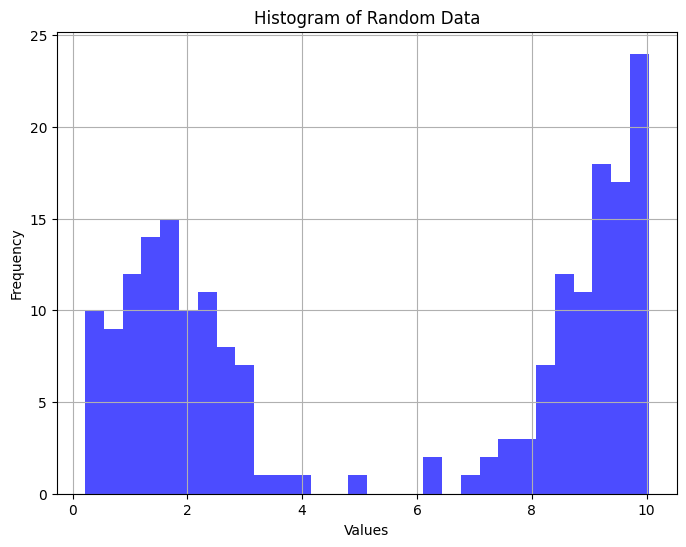

In [689]:
# data = np.quantile(multimodal_generator(100, 1,  1,1,1),np.linspace(0, 1, 10))
# data = multimodal_generator(100, 1,  1,1,1)

# Create a histogram plot
plt.figure(figsize=(8, 6))
plt.hist(data, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Random Data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

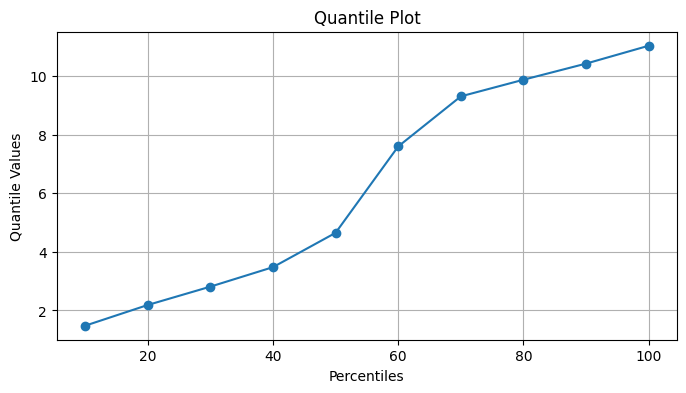

In [643]:
# Quantile plot
plt.figure(figsize=(8, 4))
percentiles = [10,20,30,40,50,60,70,80,90,100]
plt.plot(percentiles, np.quantile(multimodal_generator(100, 1,  1,1,1),np.linspace(0, 1, 10)), marker='o')
plt.title('Quantile Plot')
plt.xlabel('Percentiles')
plt.ylabel('Quantile Values')
plt.grid(True)
plt.show()

In [349]:
dist_df['imp_c_quantile_scaled'] = [rescale_to_minus_one_one(dist) for dist in dist_df["imp_c_quantile"]]

In [86]:
dist_df.columns

Index(['dist_id', 'labeled_dist_h', 'labeled_dist_a', 'imp_c',
       'imp_c_quantile', 'imp_c_quantile_scaled'],
      dtype='object')

In [59]:
y_true = label_encoder.inverse_transform(y_encoded).tolist()

NameError: name 'label_encoder' is not defined

In [644]:
training_data = generate_training_data()

In [657]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, min_samples_leaf=2)

# Train the model
# rf_model.fit(np.array(training_data.drop('label', axis=1)),training_data['label'])
rf_model.fit(np.array(X),y)

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)

In [646]:
training_data = generate_training_data()

In [658]:
y_pred_list= rf_model.predict(training_data.drop('label', axis=1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [101]:
keep_data_list = []
for i in range(10):
  training_data = generate_training_data()
  y_pred_list= rf_model.predict(training_data.drop('label', axis=1))
  keep_data = training_data.copy()
  keep_data = training_data[training_data['label'] == y_pred_list]
  keep_data_list.append(keep_data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without

In [678]:
# Save for later; cross validation random forest for truth data

# Separate features and labels
X = pd.DataFrame(dist_df['imp_c_quantile_scaled'].tolist(), columns=[f'col{i}' for i in range(1, 11)])
y = dist_df['labeled_dist_h']
# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_pred_list = []
for i in range(len(X)):


  # Initialize the Random Forest Classifier
  rf_model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, min_samples_leaf=2)

  # Train the model
  rf_model.fit(np.array(X.drop(index= i)), np.concatenate([y[:i], y[i+1:]]))

  # Print the trained model
  print(rf_model)

  # Predict the responses for test dataset
  y_pred =  rf_model.predict(X)[i]
  y_pred_list.append(y_pred)

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [686]:
# Diptest statistical test for null=unimodal distribution

# generate some bimodal random draws
N = 1000
hN = N // 2
x = np.empty(N, dtype=np.float64)
x[:hN] = np.random.normal(0.4, 1.0, hN)
x[hN:] = np.random.normal(-0.4, 1.0, hN)

# only the dip statistic
dip = diptest.dipstat(x)

# both the dip statistic and p-value
dip, pval = diptest.diptest(x)

In [834]:
bi_data = multimodal_generator(10, 1,  1,1,1)
norm_data = normal_generator(10, 1,  1,1,1)
left_data = left_tailed_generator(10, 1,  1,1,1)
right_data = right_tailed_generator(10, 1,  1,1,1)
unif_data = uniform_generator(10, 1,  1,1,1)
# np.quantile(bi_data,np.linspace(0, 1, 10))
dip, pval = diptest.diptest(left_data)
dip, pval

(0.09859078918240147, 0.48160929573848255)

In [861]:
dict_list[0]['imp_c'][0]

[2.828402441,
 3.111242685,
 0.8,
 0.6,
 1.977120325,
 1.285128212,
 3.171597559,
 1.691518698,
 0.827929025,
 0.551952683,
 0.540422211]

In [864]:
[diptest.diptest(np.array(thing['imp_c'][0]))[1] for thing in dict_list if thing['labeled_dist_h'][0] == 'bimodal']

/usr/local/lib/python3.10/dist-packages/diptest/diptest.py:168: UserWarning: Dip test is not valid for n <= 3
  warnings.warn("Dip test is not valid for n <= 3", stacklevel=1)


[0.24124846911983366,
 0.0,
 1.0,
 0.7,
 1.0,
 0.002160396277288368,
 1.0,
 0.20402252483721484,
 0.19157832979386258,
 1.0,
 0.5934025153458813,
 1.0,
 1.0]

In [418]:
y_pred_list= rf_model.predict(training_data.drop('label', axis=1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [675]:
y_pred_list= rf_model.predict(training_data.drop('label', axis=1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [676]:
y_true = [label.replace("_"," ", ) for label in training_data['label']]

In [672]:
X = pd.DataFrame(dist_df['imp_c_quantile_scaled'].tolist(), columns=[f'col{i}' for i in range(1, 11)])
y = dist_df['labeled_dist_h']

In [673]:
# y_pred_list = rf_model.predict(X)
y_true = y

In [677]:
# Assuming you have the following:
# X_test - your test features
# y_test - your true test labels
# model - your trained classifier

# Predict the responses for test dataset
# y_pred =  label_encoder.inverse_transform(rf_model.predict(X))
# y_true, y_pred_list
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_list))

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred_list))

# Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(y_true, y_pred_list))

# If it's a binary classification, calculate ROC-AUC
if len(np.unique(y_pred_list)) == 2:
    y_probs = rf_model.predict_proba(X_test)[:, 1]  # probability estimates for the positive class
    fpr, tpr, thresholds = roc_curve(y_pred_list, y_probs)
    print("AUC:", auc(fpr, tpr))

# Cross-validation (if needed)
# cv_scores = cross_val_score(model, X, y, cv=5)  # X, y are the full dataset
# print("Cross-validation scores:", cv_scores)
# print("Mean cross-validation score:", np.mean(cv_scores))


Confusion Matrix:
[[    1   116   575     5  9303]
 [   36  9964     0     0     0]
 [    0   449  9549     2     0]
 [    0     0     0 10000     0]
 [    0  7697   849     0  1454]]
Accuracy: 0.61936
Classification Report:
              precision    recall  f1-score   support

     bimodal       0.03      0.00      0.00     10000
 left tailed       0.55      1.00      0.71     10000
      normal       0.87      0.95      0.91     10000
right tailed       1.00      1.00      1.00     10000
     uniform       0.14      0.15      0.14     10000

    accuracy                           0.62     50000
   macro avg       0.52      0.62      0.55     50000
weighted avg       0.52      0.62      0.55     50000



# Cross validation loop

In [122]:
rf_model

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500,
                       random_state=123)

In [ ]:
# scaled_numeric_df

NameError: name 'scaled_numeric_df' is not defined

In [24]:
# Cross-validation: loop through all dist_ids, one at a time
# subset data to exclude unlabeled distributions 1st

data = numeric_df.dropna(subset=['dist_id'])

unique_dist_ids = data['dist_id'].unique()
np.random.shuffle(unique_dist_ids)


result_list = []

# Loop over each dist_id, leaving one out at time
for xval_id in unique_dist_ids:
    r2_list = []
    loss_list = []
    prediction_list = []
    matched_data_list = []
    model_list = []
    # Reserve data for validation
    xval_data = data[data['dist_id'] == xval_id]

    # Matched data for training
    train_data = data[data['dist_id'] != xval_id]

    reserve_data = train_data.groupby('unique_id').sample(n=1)

    for i in range(10):
        matched_data = train_data.groupby('unique_id').sample(n=1)
        matched_data = matched_data.reset_index(drop=True)

        model, test_loss, r_squared, predictions, y_test = train_model_a(matched_data)

        predictions = predict_on_reserve(reserve_data, model, min_c, max_c)

        matched_data_list.append(matched_data)
        prediction_list.append(predictions)
        model_list.append(model)
        loss_list.append(test_loss)
        r2_list.append(r_squared)

    combined_array = np.array([predictions['predictions'].values for predictions in prediction_list])
    combined_array[combined_array < 0 ] = 0

    arr_min = np.min(combined_array.flatten())
    arr_max = np.max(combined_array.flatten())

    dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
    norm_dist_array =  [np.sort((np.array([i[j] for  i in combined_array]) - arr_min) / (arr_max-arr_min)) for j in range(combined_array.shape[1])]

    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                'agbd_m', 'agbd_sd', 'agbd_n']

    scaled_numeric_df = prediction_list[0][keep_cols]

    scaled_numeric_df['norm_dist_array'] = norm_dist_array
    scaled_numeric_df.dropna(inplace=True)

    scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()

    norm_dist_array = np.array([i for i in scaled_numeric_df['norm_dist_array']])

    X = scaled_numeric_df[keep_cols]
    y = norm_dist_array

    # X = scaled_numeric_df.iloc[:, :-1]
    # y = scaled_numeric_df.iloc[:, -1]

    # x = np.array(X)
    # y = np.array(norm_dist_array)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_model(X_train.shape[1],output_shape=10)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics = ['mae'])
    model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics = ['mae'])
    model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)


    predictions = model.predict(xval_data[keep_cols])
    imp_c_scaled = np.sort(xval_data.groupby('unique_id').sample(n=1)['imp_c_scaled']*max_c+min_c)

    imp_c_quantiles = np.quantile(imp_c_scaled, np.linspace(0, 1,10))

    scaled_predictions = predictions*max_c+min_c
    prediction_quantiles = [np.quantile(prediction, np.linspace(0, 1,10)) for prediction in scaled_predictions]

    prediction_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  predictions]

    # Use the trained model to make predictions
    predicted_labels_encoded = rf_model.predict(prediction_rf_ready_predictions)

    # Decode the encoded labels back to original labels
    predicted_predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

    real_rf_ready = [rescale_to_minus_one_one(sorted(prediction)+ np.random.uniform(-0.001, 0.001, prediction.shape[0])) for prediction in  [imp_c_quantiles]]

    # Use the trained model to make predictions
    real_labels_encoded = rf_model.predict(real_rf_ready)


    # Decode the encoded labels back to original labels
    real_predicted_labels = label_encoder.inverse_transform(real_labels_encoded)

    lat_lon = [Point(xy) for xy in zip(xval_data['latitude'],xval_data['longitude'])]
    xy_sample = [Point(xy) for xy in zip(xval_data['x_sample'],xval_data['y_sample'])]
    xy_driver = [Point(xy) for xy in zip(xval_data['x_driver'],xval_data['y_driver'])]

    result_dict ={
                  "xval_id": xval_id,
                  "lat_lon": lat_lon,
                  "xy_sample": xy_sample,
                  "xy_driver": xy_driver,
                  "imp_c_scaled": imp_c_scaled,
                  "imp_c_quantiles": imp_c_quantiles,
                  "real_predicted_labels": real_predicted_labels,
                  "scaled_predictions": scaled_predictions,
                  "prediction_quantiles": prediction_quantiles,
                  "predicted_predicted_labels": predicted_predicted_labels
                }
    result_list.append(result_dict)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 933ms/step - loss: 2.8913 - val_loss: 0.0063
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2.4649 - val_loss: 0.0058
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3473 - val_loss: 0.0075
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7608 - val_loss: 0.0025
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4367 - val_loss: 0.0107
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6386 - val_loss: 0.0055
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4006 - val_loss: 0.0049
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4626 - val_loss: 0.0069
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3778 - val_loss: 0.0047
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5440 - val_loss: 0.0046
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8696 - val_loss: 0.0064
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0290 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 2.3823 - val_loss: 0.0146
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1491 - val_loss: 0.0230
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0117 - val_loss: 0.0041
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8738 - val_loss: 0.0062
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6781 - val_loss: 0.0059
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4216 - val_loss: 0.0049
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2513 - val_loss: 0.0069
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4530 - val_loss: 0.0040
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0074 - val_loss: 0.0039
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9785 - val_loss: 0.0052
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9699 - val_loss: 0.0044
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9232 - val_loss: 0.0049
Epoch 13/10

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 926ms/step - loss: 2.6201 - val_loss: 0.0102
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0609 - val_loss: 0.0062
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9833 - val_loss: 0.0055
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8447 - val_loss: 0.0073
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5852 - val_loss: 0.0037
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3990 - val_loss: 0.0038
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1889 - val_loss: 0.0046
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1121 - val_loss: 0.0043
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1770 - val_loss: 0.0055
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1228 - val_loss: 0.0043
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0268 - val_loss: 0.0049
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7918 - val_loss: 0.0047
Epoch 13/1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - loss: 3.5025 - val_loss: 0.0272
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3518 - val_loss: 0.0252
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9874 - val_loss: 0.0082
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9821 - val_loss: 0.0069
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2057 - val_loss: 0.0036
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8915 - val_loss: 0.0056
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3680 - val_loss: 0.0076
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2941 - val_loss: 0.0054
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9774 - val_loss: 0.0044
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3029 - val_loss: 0.0045
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9280 - val_loss: 0.0044
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8470 - val_loss: 0.0039
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 723ms/step - loss: 2.4209 - val_loss: 0.0406
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4538 - val_loss: 0.0275
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0665 - val_loss: 0.0107
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6239 - val_loss: 0.0069
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6971 - val_loss: 0.0153
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5667 - val_loss: 0.0089
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8161 - val_loss: 0.0151
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6489 - val_loss: 0.0065
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5953 - val_loss: 0.0078
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2039 - val_loss: 0.0070
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8536 - val_loss: 0.0054
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4261 - val_loss: 0.0058
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 715ms/step - loss: 3.2609 - val_loss: 0.0182
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5690 - val_loss: 0.0341
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5317 - val_loss: 0.0055
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7646 - val_loss: 0.0105
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8431 - val_loss: 0.0224
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2689 - val_loss: 0.0067
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5631 - val_loss: 0.0069
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4433 - val_loss: 0.0112
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3463 - val_loss: 0.0089
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2001 - val_loss: 0.0092
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0555 - val_loss: 0.0077
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9073 - val_loss: 0.0077
Epoch 13

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 717ms/step - loss: 2.6773 - val_loss: 0.0336
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4819 - val_loss: 0.0181
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2500 - val_loss: 0.0111
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3471 - val_loss: 0.0227
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8190 - val_loss: 0.0081
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2216 - val_loss: 0.0125
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1022 - val_loss: 0.0138
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7675 - val_loss: 0.0088
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5795 - val_loss: 0.0098
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9018 - val_loss: 0.0101
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8816 - val_loss: 0.0075
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9361 - val_loss: 0.0079
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.3595 - val_loss: 0.0249
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9884 - val_loss: 0.0361
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9984 - val_loss: 0.0136
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1142 - val_loss: 0.0163
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4752 - val_loss: 0.0194
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4088 - val_loss: 0.0099
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2649 - val_loss: 0.0073
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3170 - val_loss: 0.0080
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0024 - val_loss: 0.0063
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0137 - val_loss: 0.0067
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9959 - val_loss: 0.0056
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0325 - val_loss: 0.0057
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 878ms/step - loss: 3.4537 - val_loss: 0.0189
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9123 - val_loss: 0.0056
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3055 - val_loss: 0.0036
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7466 - val_loss: 0.0039
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1220 - val_loss: 0.0024
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1630 - val_loss: 0.0029
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7107 - val_loss: 0.0043
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4951 - val_loss: 0.0041
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1618 - val_loss: 0.0041
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0874 - val_loss: 0.0041
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0971 - val_loss: 0.0043
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8806 - val_loss: 0.0043
Epoch 13/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 710ms/step - loss: 2.6724 - val_loss: 0.0065
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6934 - val_loss: 0.0135
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6814 - val_loss: 0.0129
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8431 - val_loss: 0.0116
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5519 - val_loss: 0.0112
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5768 - val_loss: 0.0051
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3600 - val_loss: 0.0058
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4069 - val_loss: 0.0046
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5954 - val_loss: 0.0059
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2513 - val_loss: 0.0044
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1555 - val_loss: 0.0048
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0361 - val_loss: 0.0047
Epoch 13/1

<ipython-input-24-c852c45d897e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-24-c852c45d897e>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df.dropna(inplace=True)
<ipython-input-24-c852c45d897e>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 929ms/step - loss: 2.2079 - mae: 1.1397 - val_loss: 0.0372 - val_mae: 0.1429
Epoch 2/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.8711 - mae: 1.0568 - val_loss: 0.0350 - val_mae: 0.1359
Epoch 3/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8512 - mae: 1.0396 - val_loss: 0.0340 - val_mae: 0.1321
Epoch 4/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7339 - mae: 0.9954 - val_loss: 0.0338 - val_mae: 0.1305
Epoch 5/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6229 - mae: 0.9791 - val_loss: 0.0340 - val_mae: 0.1307
Epoch 6/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6552 - mae: 0.9758 - val_loss: 0.0343 - val_mae: 0.1314
Epoch 7/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5528 - mae: 0.9518 - val_loss: 0.0348 - val_mae: 0.1321
Epoch 8/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5506 - mae: 0.9500 - val_loss: 0.0352 - val_mae: 0.1326
Epoch 9/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4761 - mae: 0.9319 - va

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 2.3575 - val_loss: 0.0148
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7396 - val_loss: 0.0044
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.2187 - val_loss: 0.0172
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0643 - val_loss: 0.0047
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4747 - val_loss: 0.0052
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7942 - val_loss: 0.0059
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5107 - val_loss: 0.0039
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3634 - val_loss: 0.0050
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0150 - val_loss: 0.0057
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1462 - val_loss: 0.0050
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1532 - val_loss: 0.0052
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8753 - val_loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 2.2353 - val_loss: 0.0172
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 2.4235 - val_loss: 0.0132
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.2306 - val_loss: 0.0111
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6387 - val_loss: 0.0093
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5559 - val_loss: 0.0120
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5291 - val_loss: 0.0091
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3338 - val_loss: 0.0113
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4124 - val_loss: 0.0097
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3107 - val_loss: 0.0088
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0521 - val_loss: 0.0095
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1457 - val_loss: 0.0086
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9356 - val_loss: 0.0088
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.7937 - val_loss: 0.0051
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6827 - val_loss: 0.0047
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8768 - val_loss: 0.0040
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9112 - val_loss: 0.0040
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6157 - val_loss: 0.0054
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.9327 - val_loss: 0.0030
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3937 - val_loss: 0.0052
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2375 - val_loss: 0.0073
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4737 - val_loss: 0.0055
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0479 - val_loss: 0.0061
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1180 - val_loss: 0.0063
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0087 - val_loss: 0.0051
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 2.5313 - val_loss: 0.0023
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.2174 - val_loss: 0.0110
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1276 - val_loss: 0.0021
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6228 - val_loss: 0.0024
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4167 - val_loss: 0.0040
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4701 - val_loss: 0.0035
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5555 - val_loss: 0.0036
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2083 - val_loss: 0.0043
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9984 - val_loss: 0.0044
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1021 - val_loss: 0.0047
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0587 - val_loss: 0.0050
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3137 - val_loss: 0.0053
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.5455 - val_loss: 0.0150
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.5628 - val_loss: 0.0175
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.9283 - val_loss: 0.0162
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7345 - val_loss: 0.0130
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2556 - val_loss: 0.0113
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3078 - val_loss: 0.0094
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.2145 - val_loss: 0.0109
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3496 - val_loss: 0.0098
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0918 - val_loss: 0.0076
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.9686 - val_loss: 0.0073
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9327 - val_loss: 0.0076
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8869 - val_loss: 0.0075
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 2.9492 - val_loss: 0.0108
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.9436 - val_loss: 0.0454
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.3770 - val_loss: 0.0132
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9273 - val_loss: 0.0215
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7623 - val_loss: 0.0174
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4708 - val_loss: 0.0086
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2936 - val_loss: 0.0100
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2452 - val_loss: 0.0095
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0917 - val_loss: 0.0075
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0461 - val_loss: 0.0078
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9244 - val_loss: 0.0081
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0111 - val_loss: 0.0073
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 2.8447 - val_loss: 0.0041
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.0740 - val_loss: 0.0079
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8314 - val_loss: 0.0033
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7160 - val_loss: 0.0037
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0364 - val_loss: 0.0058
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5519 - val_loss: 0.0070
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3792 - val_loss: 0.0062
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2408 - val_loss: 0.0056
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1863 - val_loss: 0.0053
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1706 - val_loss: 0.0047
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0546 - val_loss: 0.0055
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1995 - val_loss: 0.0056
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 2.6367 - val_loss: 0.0037
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.9324 - val_loss: 0.0037
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9265 - val_loss: 0.0036
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7115 - val_loss: 0.0063
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1840 - val_loss: 0.0059
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6141 - val_loss: 0.0069
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3709 - val_loss: 0.0054
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2667 - val_loss: 0.0042
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3477 - val_loss: 0.0045
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9586 - val_loss: 0.0046
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3000 - val_loss: 0.0049
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9314 - val_loss: 0.0057
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 2.2608 - val_loss: 0.0044
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5208 - val_loss: 0.0047
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3449 - val_loss: 0.0049
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7252 - val_loss: 0.0112
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5423 - val_loss: 0.0095
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3711 - val_loss: 0.0097
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3960 - val_loss: 0.0065
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2285 - val_loss: 0.0065
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9524 - val_loss: 0.0065
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9588 - val_loss: 0.0055
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9748 - val_loss: 0.0059
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7834 - val_loss: 0.0058
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 2.2907 - val_loss: 0.0037
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.3822 - val_loss: 0.0040
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8588 - val_loss: 0.0028
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8573 - val_loss: 0.0029
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8225 - val_loss: 0.0038
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4130 - val_loss: 0.0029
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7410 - val_loss: 0.0030
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1152 - val_loss: 0.0035
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1999 - val_loss: 0.0035
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1207 - val_loss: 0.0036
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0393 - val_loss: 0.0037
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0656 - val_loss: 0.0039
Epo

<ipython-input-24-c852c45d897e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-24-c852c45d897e>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df.dropna(inplace=True)
<ipython-input-24-c852c45d897e>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.2356 - mae: 1.1378 - val_loss: 0.0066 - val_mae: 0.0583
Epoch 2/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0901 - mae: 1.0944 - val_loss: 0.0057 - val_mae: 0.0518
Epoch 3/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.9656 - mae: 1.0678 - val_loss: 0.0054 - val_mae: 0.0484
Epoch 4/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8998 - mae: 1.0688 - val_loss: 0.0053 - val_mae: 0.0468
Epoch 5/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8244 - mae: 1.0202 - val_loss: 0.0054 - val_mae: 0.0463
Epoch 6/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7576 - mae: 1.0233 - val_loss: 0.0055 - val_mae: 0.0459
Epoch 7/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6094 - mae: 0.9748 - val_loss: 0.0056 - val_mae: 0.0458
Epoch 8/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6388 - mae: 0.9740 - val_loss: 0.0056 - val_mae: 0.0460
Epoch 9/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5951 - mae: 0.9716 - val_l

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.5044 - val_loss: 0.0105
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6893 - val_loss: 0.0349
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5887 - val_loss: 0.0172
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8180 - val_loss: 0.0109
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5484 - val_loss: 0.0083
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2375 - val_loss: 0.0056
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1685 - val_loss: 0.0067
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2148 - val_loss: 0.0067
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1122 - val_loss: 0.0095
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0570 - val_loss: 0.0097
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0558 - val_loss: 0.0103
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8943 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 3.2844 - val_loss: 0.0123
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.8576 - val_loss: 0.0066
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.2229 - val_loss: 0.0034
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7335 - val_loss: 0.0040
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6367 - val_loss: 0.0032
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.8417 - val_loss: 0.0059
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4585 - val_loss: 0.0064
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3017 - val_loss: 0.0051
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1525 - val_loss: 0.0052
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.3812 - val_loss: 0.0054
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.5467 - val_loss: 0.0058
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1098 - val_loss: 0.0064
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 3.4150 - val_loss: 0.0212
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3958 - val_loss: 0.0082
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0374 - val_loss: 0.0108
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8010 - val_loss: 0.0082
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5031 - val_loss: 0.0064
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7595 - val_loss: 0.0066
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5777 - val_loss: 0.0055
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6385 - val_loss: 0.0057
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4240 - val_loss: 0.0051
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5272 - val_loss: 0.0044
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1251 - val_loss: 0.0045
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1734 - val_loss: 0.0046
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.9999 - val_loss: 0.0139
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8875 - val_loss: 0.0063
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1522 - val_loss: 0.0056
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5117 - val_loss: 0.0065
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4494 - val_loss: 0.0065
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6198 - val_loss: 0.0059
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2851 - val_loss: 0.0066
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2066 - val_loss: 0.0061
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1351 - val_loss: 0.0056
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0073 - val_loss: 0.0058
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1146 - val_loss: 0.0061
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9424 - val_loss: 0.0060
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.2881 - val_loss: 0.0407
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.2340 - val_loss: 0.0414
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.5579 - val_loss: 0.0415
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8469 - val_loss: 0.0321
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.6748 - val_loss: 0.0277
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3313 - val_loss: 0.0148
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4305 - val_loss: 0.0158
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.4903 - val_loss: 0.0086
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0557 - val_loss: 0.0072
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0210 - val_loss: 0.0066
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8691 - val_loss: 0.0063
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9184 - val_loss: 0.0067
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 2.6307 - val_loss: 0.0317
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 2.7525 - val_loss: 0.0019
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5848 - val_loss: 0.0043
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8001 - val_loss: 0.0125
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7300 - val_loss: 0.0098
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5667 - val_loss: 0.0083
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5383 - val_loss: 0.0098
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2435 - val_loss: 0.0062
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0320 - val_loss: 0.0067
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0543 - val_loss: 0.0071
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0522 - val_loss: 0.0061
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2381 - val_loss: 0.0065
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 2.6253 - val_loss: 0.0104
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.1413 - val_loss: 0.0021
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.1165 - val_loss: 0.0022
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9221 - val_loss: 0.0024
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.1195 - val_loss: 0.0023
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.8515 - val_loss: 0.0026
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3936 - val_loss: 0.0031
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4575 - val_loss: 0.0034
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0977 - val_loss: 0.0038
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.1045 - val_loss: 0.0039
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9326 - val_loss: 0.0040
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2134 - val_loss: 0.0040
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 2.4803 - val_loss: 0.0050
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1119 - val_loss: 0.0032
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3627 - val_loss: 0.0091
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9750 - val_loss: 0.0075
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5206 - val_loss: 0.0074
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5206 - val_loss: 0.0067
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3125 - val_loss: 0.0050
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3055 - val_loss: 0.0049
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2029 - val_loss: 0.0053
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2175 - val_loss: 0.0043
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0761 - val_loss: 0.0046
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0423 - val_loss: 0.0050
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 2.2895 - val_loss: 0.0243
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.1512 - val_loss: 0.0114
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0180 - val_loss: 0.0136
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.4445 - val_loss: 0.0053
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5421 - val_loss: 0.0054
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6485 - val_loss: 0.0080
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6750 - val_loss: 0.0083
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2666 - val_loss: 0.0111
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3682 - val_loss: 0.0117
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0593 - val_loss: 0.0107
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9743 - val_loss: 0.0110
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0110 - val_loss: 0.0101
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 3.3641 - val_loss: 0.0367
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8237 - val_loss: 0.0115
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9831 - val_loss: 0.0172
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8358 - val_loss: 0.0149
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.1635 - val_loss: 0.0127
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3459 - val_loss: 0.0109
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4878 - val_loss: 0.0097
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1580 - val_loss: 0.0112
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2078 - val_loss: 0.0097
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9379 - val_loss: 0.0090
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8657 - val_loss: 0.0086
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9083 - val_loss: 0.0089
Epo

<ipython-input-24-c852c45d897e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-24-c852c45d897e>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df.dropna(inplace=True)
<ipython-input-24-c852c45d897e>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 2.1388 - mae: 1.0954 - val_loss: 0.0141 - val_mae: 0.0801
Epoch 2/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.9259 - mae: 1.0520 - val_loss: 0.0134 - val_mae: 0.0755
Epoch 3/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8226 - mae: 1.0276 - val_loss: 0.0130 - val_mae: 0.0738
Epoch 4/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7448 - mae: 1.0184 - val_loss: 0.0125 - val_mae: 0.0720
Epoch 5/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6310 - mae: 0.9965 - val_loss: 0.0118 - val_mae: 0.0696
Epoch 6/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6557 - mae: 0.9869 - val_loss: 0.0113 - val_mae: 0.0679
Epoch 7/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4977 - mae: 0.9473 - val_loss: 0.0110 - val_mae: 0.0666
Epoch 8/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4096 - mae: 0.9150 - val_loss: 0.0107 - val_mae: 0.0656
Epoch 9/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5330 - mae: 0.9608 - val_l

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.7496 - val_loss: 0.0027
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.7493 - val_loss: 0.0112
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9621 - val_loss: 0.0040
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8833 - val_loss: 0.0049
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7693 - val_loss: 0.0100
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5042 - val_loss: 0.0085
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3488 - val_loss: 0.0071
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4297 - val_loss: 0.0075
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7017 - val_loss: 0.0065
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1683 - val_loss: 0.0070
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1460 - val_loss: 0.0075
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8496 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 3.8268 - val_loss: 0.0110
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.7920 - val_loss: 0.0429
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.1999 - val_loss: 0.0218
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.7491 - val_loss: 0.0103
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5489 - val_loss: 0.0174
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6332 - val_loss: 0.0114
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.5465 - val_loss: 0.0066
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3304 - val_loss: 0.0082
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.2819 - val_loss: 0.0098
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.3559 - val_loss: 0.0087
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.1107 - val_loss: 0.0083
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1525 - val_loss: 0.0082
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 3.2011 - val_loss: 0.0092
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.5101 - val_loss: 0.0046
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0844 - val_loss: 0.0032
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6239 - val_loss: 0.0026
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4013 - val_loss: 0.0036
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1068 - val_loss: 0.0049
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2730 - val_loss: 0.0045
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0292 - val_loss: 0.0045
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0114 - val_loss: 0.0048
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0553 - val_loss: 0.0051
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9364 - val_loss: 0.0053
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7373 - val_loss: 0.0056
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 2.6606 - val_loss: 0.0070
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.0638 - val_loss: 0.0114
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.0058 - val_loss: 0.0053
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0306 - val_loss: 0.0035
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.9947 - val_loss: 0.0054
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.1067 - val_loss: 0.0044
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.2637 - val_loss: 0.0051
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.3966 - val_loss: 0.0062
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2839 - val_loss: 0.0059
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2045 - val_loss: 0.0057
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0512 - val_loss: 0.0060
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0023 - val_loss: 0.0063
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 2.7491 - val_loss: 0.0073
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 2.3098 - val_loss: 0.0178
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0646 - val_loss: 0.0187
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1402 - val_loss: 0.0086
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9286 - val_loss: 0.0071
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3887 - val_loss: 0.0136
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5710 - val_loss: 0.0115
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3520 - val_loss: 0.0088
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2023 - val_loss: 0.0082
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1314 - val_loss: 0.0078
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9214 - val_loss: 0.0073
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0787 - val_loss: 0.0072
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 3.2615 - val_loss: 0.0102
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.5771 - val_loss: 0.0091
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.3272 - val_loss: 0.0040
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.2022 - val_loss: 0.0057
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.8298 - val_loss: 0.0037
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4203 - val_loss: 0.0046
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3531 - val_loss: 0.0043
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2160 - val_loss: 0.0043
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1815 - val_loss: 0.0034
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2745 - val_loss: 0.0038
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1377 - val_loss: 0.0039
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0795 - val_loss: 0.0037
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.4060 - val_loss: 0.0195
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4231 - val_loss: 0.0193
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2898 - val_loss: 0.0162
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7356 - val_loss: 0.0098
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3415 - val_loss: 0.0097
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5985 - val_loss: 0.0061
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5335 - val_loss: 0.0057
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3580 - val_loss: 0.0067
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2969 - val_loss: 0.0068
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2418 - val_loss: 0.0068
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9980 - val_loss: 0.0067
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9920 - val_loss: 0.0068
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 2.4875 - val_loss: 0.0145
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9326 - val_loss: 0.0072
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5099 - val_loss: 0.0064
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5562 - val_loss: 0.0060
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4709 - val_loss: 0.0095
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5918 - val_loss: 0.0095
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1007 - val_loss: 0.0093
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2695 - val_loss: 0.0083
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2923 - val_loss: 0.0069
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0515 - val_loss: 0.0065
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1032 - val_loss: 0.0066
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0630 - val_loss: 0.0075
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.8426 - val_loss: 0.0183
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.8951 - val_loss: 0.0066
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.6036 - val_loss: 0.0096
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.4353 - val_loss: 0.0047
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4536 - val_loss: 0.0050
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4676 - val_loss: 0.0077
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4262 - val_loss: 0.0056
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4131 - val_loss: 0.0048
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2052 - val_loss: 0.0048
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1400 - val_loss: 0.0050
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2467 - val_loss: 0.0051
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0536 - val_loss: 0.0052
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 2.7434 - val_loss: 0.0087
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8103 - val_loss: 0.0101
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.2284 - val_loss: 0.0059
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.1235 - val_loss: 0.0085
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.6387 - val_loss: 0.0082
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2854 - val_loss: 0.0083
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3241 - val_loss: 0.0106
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.1836 - val_loss: 0.0091
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0903 - val_loss: 0.0083
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9568 - val_loss: 0.0085
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2247 - val_loss: 0.0077
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9111 - val_loss: 0.0072
Epo

<ipython-input-24-c852c45d897e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-24-c852c45d897e>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df.dropna(inplace=True)
<ipython-input-24-c852c45d897e>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.2059 - mae: 1.1184 - val_loss: 0.0075 - val_mae: 0.0550
Epoch 2/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.9414 - mae: 1.0613 - val_loss: 0.0073 - val_mae: 0.0527
Epoch 3/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.7609 - mae: 1.0077 - val_loss: 0.0075 - val_mae: 0.0534
Epoch 4/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.8509 - mae: 1.0382 - val_loss: 0.0078 - val_mae: 0.0543
Epoch 5/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7223 - mae: 0.9964 - val_loss: 0.0080 - val_mae: 0.0555
Epoch 6/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.6629 - mae: 0.9851 - val_loss: 0.0080 - val_mae: 0.0563
Epoch 7/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5511 - mae: 0.9483 - val_loss: 0.0080 - val_mae: 0.0562
Epoch 8/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5106 - mae: 0.9523 - val_loss: 0.0080 - val_mae: 0.0554
Epoch 9/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4969 - mae: 0.9486 - val_l

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 2.9185 - val_loss: 0.0051
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.0406 - val_loss: 0.0381
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.4942 - val_loss: 0.0142
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.0469 - val_loss: 0.0107
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4149 - val_loss: 0.0116
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7564 - val_loss: 0.0082
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4939 - val_loss: 0.0080
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1580 - val_loss: 0.0092
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0820 - val_loss: 0.0091
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0254 - val_loss: 0.0081
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3104 - val_loss: 0.0091
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0178 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 3.1050 - val_loss: 0.0161
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7348 - val_loss: 0.0070
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.5669 - val_loss: 0.0058
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.3213 - val_loss: 0.0029
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5950 - val_loss: 0.0049
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5181 - val_loss: 0.0032
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4163 - val_loss: 0.0037
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1979 - val_loss: 0.0038
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3533 - val_loss: 0.0036
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9725 - val_loss: 0.0035
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9748 - val_loss: 0.0038
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8387 - val_loss: 0.0043
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 2.2325 - val_loss: 0.0557
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1084 - val_loss: 0.0250
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8422 - val_loss: 0.0270
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7206 - val_loss: 0.0093
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6255 - val_loss: 0.0141
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6454 - val_loss: 0.0142
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5571 - val_loss: 0.0133
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4255 - val_loss: 0.0117
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2628 - val_loss: 0.0103
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1055 - val_loss: 0.0107
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0159 - val_loss: 0.0104
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8971 - val_loss: 0.0098
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 3.1747 - val_loss: 0.0052
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0213 - val_loss: 0.0155
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.7228 - val_loss: 0.0039
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.1029 - val_loss: 0.0035
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9171 - val_loss: 0.0046
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4570 - val_loss: 0.0042
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.8024 - val_loss: 0.0026
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3670 - val_loss: 0.0036
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0870 - val_loss: 0.0039
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0828 - val_loss: 0.0037
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8452 - val_loss: 0.0039
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8373 - val_loss: 0.0040
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 2.8339 - val_loss: 0.0059
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6793 - val_loss: 0.0037
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1733 - val_loss: 0.0049
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9156 - val_loss: 0.0042
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7132 - val_loss: 0.0036
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8378 - val_loss: 0.0044
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7048 - val_loss: 0.0041
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3986 - val_loss: 0.0037
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4010 - val_loss: 0.0040
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1726 - val_loss: 0.0042
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1986 - val_loss: 0.0038
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0273 - val_loss: 0.0039
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.7056 - val_loss: 0.0180
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.1747 - val_loss: 0.0067
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9291 - val_loss: 0.0120
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8867 - val_loss: 0.0057
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6457 - val_loss: 0.0061
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6310 - val_loss: 0.0051
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3058 - val_loss: 0.0051
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1804 - val_loss: 0.0045
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3666 - val_loss: 0.0048
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2277 - val_loss: 0.0047
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9690 - val_loss: 0.0045
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1857 - val_loss: 0.0050
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.4346 - val_loss: 0.0028
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.1552 - val_loss: 0.0117
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.3169 - val_loss: 0.0066
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.8300 - val_loss: 0.0036
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.9672 - val_loss: 0.0057
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.5224 - val_loss: 0.0060
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1478 - val_loss: 0.0062
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.2347 - val_loss: 0.0055
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9784 - val_loss: 0.0053
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0524 - val_loss: 0.0058
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8931 - val_loss: 0.0063
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8852 - val_loss: 0.0058
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 2.2458 - val_loss: 0.0103
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1382 - val_loss: 0.0075
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.2861 - val_loss: 0.0061
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5546 - val_loss: 0.0050
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8985 - val_loss: 0.0062
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.5191 - val_loss: 0.0050
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6892 - val_loss: 0.0059
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3476 - val_loss: 0.0057
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2199 - val_loss: 0.0058
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3283 - val_loss: 0.0068
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0542 - val_loss: 0.0063
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9962 - val_loss: 0.0058
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 3.3422 - val_loss: 0.0163
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.6178 - val_loss: 0.0029
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.5389 - val_loss: 0.0064
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3950 - val_loss: 0.0060
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9330 - val_loss: 0.0049
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6353 - val_loss: 0.0048
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9130 - val_loss: 0.0051
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4558 - val_loss: 0.0058
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3764 - val_loss: 0.0053
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4981 - val_loss: 0.0050
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2779 - val_loss: 0.0053
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9723 - val_loss: 0.0054
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 2.6215 - val_loss: 0.0064
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.8307 - val_loss: 0.0039
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4901 - val_loss: 0.0052
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0343 - val_loss: 0.0053
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4473 - val_loss: 0.0067
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4092 - val_loss: 0.0097
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0216 - val_loss: 0.0105
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0804 - val_loss: 0.0091
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1808 - val_loss: 0.0088
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1427 - val_loss: 0.0077
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7938 - val_loss: 0.0070
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9230 - val_loss: 0.0078
Epo

<ipython-input-24-c852c45d897e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-24-c852c45d897e>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df.dropna(inplace=True)
<ipython-input-24-c852c45d897e>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.0491 - mae: 1.0804 - val_loss: 0.0067 - val_mae: 0.0603
Epoch 2/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.9542 - mae: 1.0647 - val_loss: 0.0062 - val_mae: 0.0550
Epoch 3/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.9533 - mae: 1.0406 - val_loss: 0.0062 - val_mae: 0.0556
Epoch 4/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.7524 - mae: 1.0052 - val_loss: 0.0064 - val_mae: 0.0564
Epoch 5/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.7985 - mae: 1.0144 - val_loss: 0.0065 - val_mae: 0.0569
Epoch 6/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.6990 - mae: 1.0001 - val_loss: 0.0066 - val_mae: 0.0570
Epoch 7/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6311 - mae: 0.9806 - val_loss: 0.0067 - val_mae: 0.0570
Epoch 8/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.6048 - mae: 0.9604 - val_loss: 0.0068 - val_mae: 0.0573
Epoch 9/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5554 - mae: 0.9495 - val_l

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 750ms/step - loss: 3.7252 - val_loss: 0.0074
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.7982 - val_loss: 0.0096
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6206 - val_loss: 0.0065
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3985 - val_loss: 0.0025
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0166 - val_loss: 0.0035
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9023 - val_loss: 0.0042
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2957 - val_loss: 0.0034
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2886 - val_loss: 0.0052
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2779 - val_loss: 0.0081
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4562 - val_loss: 0.0042
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2469 - val_loss: 0.0049
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0757 - val_loss: 0.0044


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 729ms/step - loss: 1.7878 - val_loss: 0.0077
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.3544 - val_loss: 0.0081
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8679 - val_loss: 0.0041
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3450 - val_loss: 0.0052
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1152 - val_loss: 0.0093
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9645 - val_loss: 0.0050
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0104 - val_loss: 0.0061
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0118 - val_loss: 0.0055
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4380 - val_loss: 0.0055
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9508 - val_loss: 0.0047
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9900 - val_loss: 0.0055
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8751 - val_loss: 0.0055


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 2.2777 - val_loss: 0.0044
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.0004 - val_loss: 0.0041
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8148 - val_loss: 0.0040
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7219 - val_loss: 0.0044
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7549 - val_loss: 0.0040
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6536 - val_loss: 0.0062
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8764 - val_loss: 0.0043
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5073 - val_loss: 0.0043
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0522 - val_loss: 0.0040
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9791 - val_loss: 0.0043
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8861 - val_loss: 0.0043
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7971 - val_loss: 0.0045
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 791ms/step - loss: 2.5183 - val_loss: 0.0524
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8286 - val_loss: 0.0249
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1437 - val_loss: 0.0111
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.8709 - val_loss: 0.0075
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6151 - val_loss: 0.0106
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3112 - val_loss: 0.0092
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.6090 - val_loss: 0.0124
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3377 - val_loss: 0.0091
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1034 - val_loss: 0.0092
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9454 - val_loss: 0.0075
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9344 - val_loss: 0.0075
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8949 - val_loss: 0.0072


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 865ms/step - loss: 2.2293 - val_loss: 0.0208
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5997 - val_loss: 0.0192
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.3355 - val_loss: 0.0098
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3926 - val_loss: 0.0309
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.8248 - val_loss: 0.0084
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6464 - val_loss: 0.0100
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1062 - val_loss: 0.0084
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3925 - val_loss: 0.0109
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2183 - val_loss: 0.0058
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2463 - val_loss: 0.0139
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1305 - val_loss: 0.0085
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0135 - val_loss: 0.0070


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 725ms/step - loss: 2.8587 - val_loss: 0.0683
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.7646 - val_loss: 0.0101
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0373 - val_loss: 0.0170
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1198 - val_loss: 0.0078
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7913 - val_loss: 0.0048
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2856 - val_loss: 0.0066
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8683 - val_loss: 0.0044
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0558 - val_loss: 0.0045
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4783 - val_loss: 0.0048
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0553 - val_loss: 0.0048
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4349 - val_loss: 0.0051
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8668 - val_loss: 0.0053


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.0974 - val_loss: 0.0170
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 2.3655 - val_loss: 0.0190
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9462 - val_loss: 0.0081
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0777 - val_loss: 0.0122
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.0776 - val_loss: 0.0072
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9646 - val_loss: 0.0169
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7342 - val_loss: 0.0090
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7302 - val_loss: 0.0150
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3138 - val_loss: 0.0107
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1324 - val_loss: 0.0063
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0796 - val_loss: 0.0057
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1760 - val_loss: 0.0048
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 754ms/step - loss: 1.9705 - val_loss: 0.0026
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.2577 - val_loss: 0.0075
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.4185 - val_loss: 0.0026
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.2737 - val_loss: 0.0038
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7291 - val_loss: 0.0028
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4421 - val_loss: 0.0045
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6154 - val_loss: 0.0045
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6676 - val_loss: 0.0055
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4326 - val_loss: 0.0044
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1063 - val_loss: 0.0047
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1463 - val_loss: 0.0039
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.9189 - val_loss: 0.0041


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 725ms/step - loss: 3.3924 - val_loss: 0.0459
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5390 - val_loss: 0.0103
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.3884 - val_loss: 0.0137
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.2946 - val_loss: 0.0037
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4201 - val_loss: 0.0048
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4072 - val_loss: 0.0038
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4681 - val_loss: 0.0068
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4634 - val_loss: 0.0043
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4879 - val_loss: 0.0048
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0991 - val_loss: 0.0043
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0058 - val_loss: 0.0042
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7602 - val_loss: 0.0045


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 727ms/step - loss: 3.1826 - val_loss: 0.0150
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.8240 - val_loss: 0.0239
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.0276 - val_loss: 0.0029
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8676 - val_loss: 0.0068
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1452 - val_loss: 0.0072
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.9226 - val_loss: 0.0065
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9591 - val_loss: 0.0038
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2301 - val_loss: 0.0052
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0897 - val_loss: 0.0041
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0161 - val_loss: 0.0042
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9304 - val_loss: 0.0048
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9795 - val_loss: 0.0046


<ipython-input-24-c852c45d897e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-24-c852c45d897e>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df.dropna(inplace=True)
<ipython-input-24-c852c45d897e>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 727ms/step - loss: 1.9329 - mae: 1.0487 - val_loss: 0.0277 - val_mae: 0.1130
Epoch 2/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8504 - mae: 1.0355 - val_loss: 0.0256 - val_mae: 0.1108
Epoch 3/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7336 - mae: 1.0058 - val_loss: 0.0243 - val_mae: 0.1111
Epoch 4/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7337 - mae: 1.0034 - val_loss: 0.0233 - val_mae: 0.1115
Epoch 5/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5419 - mae: 0.9604 - val_loss: 0.0225 - val_mae: 0.1108
Epoch 6/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5574 - mae: 0.9594 - val_loss: 0.0219 - val_mae: 0.1093
Epoch 7/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5679 - mae: 0.9700 - val_loss: 0.0215 - val_mae: 0.1083
Epoch 8/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4202 - mae: 0.9156 - val_loss: 0.0214 - val_mae: 0.1078
Epoch 9/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4148 - mae: 0.9151 - va

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 3.8766 - val_loss: 0.0070
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.7027 - val_loss: 0.0219
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1666 - val_loss: 0.0230
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5770 - val_loss: 0.0065
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.8924 - val_loss: 0.0078
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4467 - val_loss: 0.0103
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.5285 - val_loss: 0.0059
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4689 - val_loss: 0.0049
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5348 - val_loss: 0.0049
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2426 - val_loss: 0.0047
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3253 - val_loss: 0.0043
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1105 - val_loss: 0.0042
Ep

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 2.5400 - val_loss: 0.0075
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.2205 - val_loss: 0.0079
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3924 - val_loss: 0.0084
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9417 - val_loss: 0.0047
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5596 - val_loss: 0.0042
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9741 - val_loss: 0.0050
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6315 - val_loss: 0.0074
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.3345 - val_loss: 0.0081
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1555 - val_loss: 0.0074
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.1962 - val_loss: 0.0078
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0671 - val_loss: 0.0079
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9661 - val_loss: 0.0071
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 2.8947 - val_loss: 0.0056
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.5038 - val_loss: 0.0038
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.0922 - val_loss: 0.0049
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5087 - val_loss: 0.0053
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7440 - val_loss: 0.0044
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3610 - val_loss: 0.0066
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4184 - val_loss: 0.0069
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4743 - val_loss: 0.0056
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5542 - val_loss: 0.0063
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1897 - val_loss: 0.0059
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2383 - val_loss: 0.0060
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1039 - val_loss: 0.0074
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 2.4774 - val_loss: 0.0052
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.2728 - val_loss: 0.0114
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9047 - val_loss: 0.0048
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.9567 - val_loss: 0.0066
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.5284 - val_loss: 0.0092
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8184 - val_loss: 0.0092
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.5767 - val_loss: 0.0066
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4203 - val_loss: 0.0052
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.3985 - val_loss: 0.0050
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1663 - val_loss: 0.0051
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9330 - val_loss: 0.0051
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1544 - val_loss: 0.0045
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 2.7392 - val_loss: 0.0096
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.9359 - val_loss: 0.0040
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2577 - val_loss: 0.0035
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9692 - val_loss: 0.0048
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8981 - val_loss: 0.0043
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.1612 - val_loss: 0.0053
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.5282 - val_loss: 0.0049
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0983 - val_loss: 0.0048
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1714 - val_loss: 0.0048
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9936 - val_loss: 0.0046
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9673 - val_loss: 0.0047
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9841 - val_loss: 0.0049
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.2000 - val_loss: 0.0032
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.0129 - val_loss: 0.0031
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6877 - val_loss: 0.0044
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8704 - val_loss: 0.0049
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6859 - val_loss: 0.0065
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6200 - val_loss: 0.0049
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3216 - val_loss: 0.0055
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5983 - val_loss: 0.0054
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2535 - val_loss: 0.0053
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1866 - val_loss: 0.0056
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0998 - val_loss: 0.0051
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0574 - val_loss: 0.0053
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 1.9192 - val_loss: 0.0077
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.6859 - val_loss: 0.0028
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7019 - val_loss: 0.0066
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.8646 - val_loss: 0.0066
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6382 - val_loss: 0.0070
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4775 - val_loss: 0.0051
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8791 - val_loss: 0.0043
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1098 - val_loss: 0.0055
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2445 - val_loss: 0.0049
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2418 - val_loss: 0.0054
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0225 - val_loss: 0.0057
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0111 - val_loss: 0.0055
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 2.8330 - val_loss: 0.0064
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 2.1883 - val_loss: 0.0256
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1126 - val_loss: 0.0059
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9634 - val_loss: 0.0111
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4781 - val_loss: 0.0089
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1520 - val_loss: 0.0064
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1544 - val_loss: 0.0076
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1601 - val_loss: 0.0066
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0952 - val_loss: 0.0064
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9372 - val_loss: 0.0066
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1277 - val_loss: 0.0067
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0753 - val_loss: 0.0072
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 2.0315 - val_loss: 0.0144
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.1283 - val_loss: 0.0086
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.0820 - val_loss: 0.0098
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.3976 - val_loss: 0.0075
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4669 - val_loss: 0.0072
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.3160 - val_loss: 0.0056
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7466 - val_loss: 0.0043
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.1584 - val_loss: 0.0035
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.2101 - val_loss: 0.0040
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1866 - val_loss: 0.0036
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8665 - val_loss: 0.0040
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0161 - val_loss: 0.0045
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 3.9835 - val_loss: 0.0083
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.6016 - val_loss: 0.0074
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3465 - val_loss: 0.0032
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5247 - val_loss: 0.0050
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6004 - val_loss: 0.0036
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5945 - val_loss: 0.0037
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5708 - val_loss: 0.0060
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1573 - val_loss: 0.0057
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2573 - val_loss: 0.0053
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1096 - val_loss: 0.0055
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1572 - val_loss: 0.0056
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1431 - val_loss: 0.0057
Epo

<ipython-input-24-c852c45d897e>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-24-c852c45d897e>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df.dropna(inplace=True)
<ipython-input-24-c852c45d897e>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 2.2000 - mae: 1.1195 - val_loss: 0.0168 - val_mae: 0.0905
Epoch 2/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.9030 - mae: 1.0452 - val_loss: 0.0142 - val_mae: 0.0802
Epoch 3/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.7482 - mae: 1.0136 - val_loss: 0.0129 - val_mae: 0.0740
Epoch 4/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.6998 - mae: 0.9985 - val_loss: 0.0123 - val_mae: 0.0705
Epoch 5/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.7317 - mae: 1.0157 - val_loss: 0.0121 - val_mae: 0.0690
Epoch 6/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.6587 - mae: 1.0027 - val_loss: 0.0121 - val_mae: 0.0686
Epoch 7/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5784 - mae: 0.9554 - val_loss: 0.0120 - val_mae: 0.0688
Epoch 8/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.6215 - mae: 0.9734 - val_loss: 0.0121 - val_mae: 0.0697
Epoch 9/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.5974 - mae: 0.9569 - val_l

KeyboardInterrupt: 

In [ ]:
result_list[4]['imp_c_quantiles']


In [ ]:
gdf = gpd.GeoDataFrame({'median ': [i[5]for i in result_list[4]['prediction_quantiles']],'median_z': [i[5]-result_list[4]['imp_c_quantiles'][5] for i in result_list[4]['prediction_quantiles']],'geometry': result_list[4]['xy_driver']})
gdf.set_crs(epsg = 32604, inplace=True)
gdf.to_file('test.gpkg')

In [ ]:
# Calculate average R-squared and loss
average_r_squared = np.mean(r2_list)
average_loss = np.mean(loss_list)

print(average_r_squared)
print(average_loss)

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(r2_list, bins=20, color='blue', alpha=0.7)
plt.title('R-squared Distribution')
plt.xlabel('R-squared')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(loss_list, bins=20, color='red', alpha=0.7)
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
dist_id_performance = {}
for i, dist_id in enumerate(unique_dist_ids):
    if dist_id not in dist_id_performance:
        dist_id_performance[dist_id] = []
    dist_id_performance[dist_id].append(r2_list[i])

# Print R-squared by dist_id
for dist_id, performances in dist_id_performance.items():
    print(f"Dist_id {dist_id} - Average R-squared: {np.mean(performances)}")